In [8]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

## Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [11]:
engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df=pd.read_sql_query("select * from heartdisease", con=engine)

engine.dispose()

In [12]:
#Make sure the number of rows divides evenly into four samples.
rows=heartdisease_df.shape[0]-heartdisease_df.shape[0]%2
df=heartdisease_df.iloc[:rows, :]

# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

#Normalize
X_std =StandardScaler().fit_transform(X)

#Data frame to store features and predicted cluster memberships.
ypred=pd.DataFrame()

#Create the two-feature PCA for graphing purposes
pca = PCA(n_components=2)
X_pca=pca.fit_transform(X_std)

#Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

#Pass a list of tuples and a counter that increments each time we go through the loop
#The tuples are the data to be used by k-means, and the PCA-derived features for graphing.
#We use k-means to fit a model to the data, then store the predicted values and the two-feature
#PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    #Put the features into ypred
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:,0]
    ypred["pca_f2"+"_sample"+str(counter)] =data[1][:, 1]
    
    #Generate cluster predictions and store them for clusters 2 to 4
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred["clust"+str(nclust)+"_sample" + str(counter)]=pred

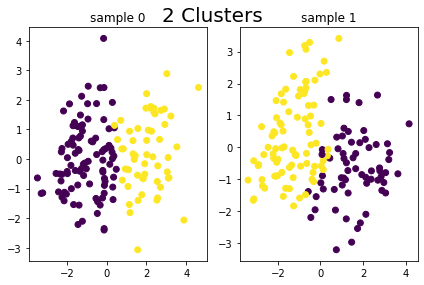

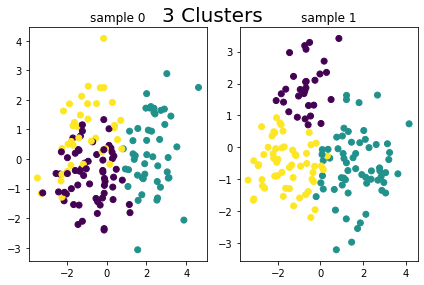

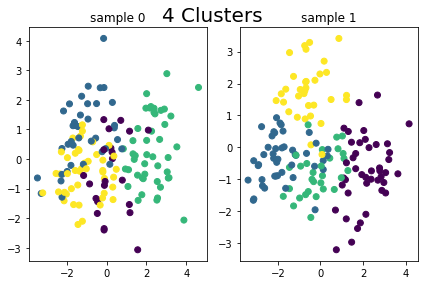

In [14]:
#For each number of clusters, plot the clusters using the pca features for each sample
for cluster in range(2, 5):
    # Make a grid of subplots
    f, axarr = plt.subplots(1,2)
    
    #Make a plot for each sample
    for i in range(2):
        
        #PCA-created features
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]
        
        #Cluster assignments
        c= ypred["clust{}_sample{}".format(cluster, i)]
        
        # Assign the subplot to its place on the grid
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
        
    # Space out the plots so that the headings dont overlap axis values
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

The two cluster solution seems to be the only consistent solution among all.

## Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [15]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_2)))
print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_3)))
print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for two cluster k-means: 0.280694132678885
ARI for two cluster k-means: 0.1968993286830863


According to the results, the best solution is the two cluster colution as its ARI score is the highest.

## Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [16]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_2, metric="euclidean")))
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_3, metric="euclidean")))
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_4, metric="euclidean")))

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for two cluster k-means: 0.12862190702187828
Silhouette score for two cluster k-means: 0.13186062012858554


The best solution is the two cluster.